# **1. Perkenalan Dataset**

## 📽️ Sistem Rekomendasi Film: Collaborative Filtering & Deep Learning

Proyek ini membangun sistem rekomendasi film menggunakan pendekatan:
- **Collaborative Filtering berbasis item (Item-to-Item KNN)**
- **Deep Learning berbasis embedding**

Dataset yang digunakan berasal dari **MovieLens Latest Small** dan terdiri dari:
- `movies.csv`: Informasi ID dan judul film.
- `ratings.csv`: Data rating dari pengguna terhadap film.

🎯 **Tujuan**: Memberikan rekomendasi film serupa berdasarkan pola penilaian pengguna lain serta mengeksplorasi model pembelajaran mendalam.

# **2. Import Library**

## 📦 Import Library

Library yang digunakan meliputi:
- `pandas`, `numpy`: Manipulasi dan analisis data.
- `sklearn`: Model KNN, metrik, dan pemrosesan.
- `tensorflow.keras`: Membangun model deep learning berbasis embedding.
- `matplotlib`, `seaborn`: Visualisasi data.

In [30]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy.sparse import csr_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error

# **3. Memuat Dataset**

## 📥 Memuat Dataset

Dataset diimpor dari file CSV lokal. Berikut struktur dasar data:
- Jumlah film: {movies.shape[0]}
- Jumlah rating: {ratings.shape[0]}

Berikut beberapa baris awal dari masing-masing dataset:

In [31]:
# Load dataset dari CSV
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')

In [32]:
# Menampilkan beberapa baris awal
print("Movies dataset:")
movies.head()

Movies dataset:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [33]:
print("Ratings dataset:")
ratings.head()

Ratings dataset:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [34]:
movies.shape

(9742, 3)

In [35]:
ratings.shape

(100836, 4)

# **4. Exploratory Data Analysis (EDA)**

## 🔍 Exploratory Data Analysis (EDA)

Tujuan EDA adalah memahami distribusi rating, aktivitas pengguna, dan popularitas film.

### 🎞️ Distribusi Jumlah Rating per Film
Menunjukkan berapa banyak pengguna yang memberi rating per film. Threshold minimum: 10 rating.

### 👤 Aktivitas Pengguna
Distribusi jumlah film yang dirating per pengguna. Threshold minimum: 60 rating.

### ⭐ Distribusi Rating
Distribusi rating pada skala 0-5. Sebagian besar rating berada di kisaran 3-5.

### 🏆 Top 10 Film Berdasarkan Rating Rata-rata (vote > 100)
Berikut film dengan penilaian tertinggi:

In [36]:
# Bentuk pivot tabel dari rating
data = pd.pivot_table(ratings, index='movieId', columns='userId', values='rating')

In [37]:
# Distribusi jumlah vote per movie dan per user
numberOf_user_voted_for_movie = ratings.groupby('movieId')['rating'].agg('count').reset_index()
numberOf_movies_voted_by_user = ratings.groupby('userId')['rating'].agg('count').reset_index()


Text(0.5, 1.0, 'Jumlah rating per movie')

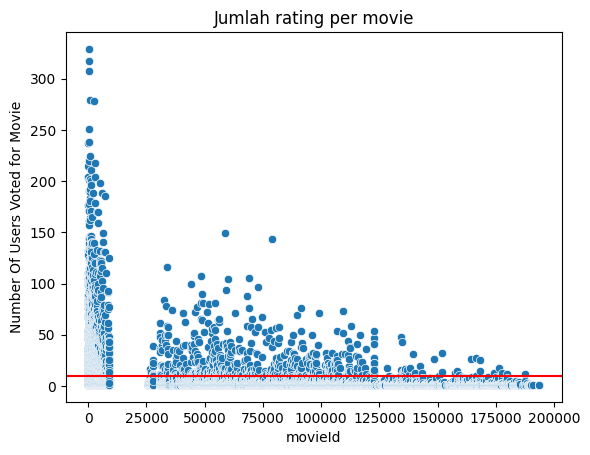

In [38]:
# Visualisasi threshold filter
plt.figure()
sns.scatterplot(y='rating', x='movieId', data=numberOf_user_voted_for_movie)
plt.axhline(y=10, color='r')
plt.ylabel('Number Of Users Voted for Movie')
plt.title('Jumlah rating per movie')

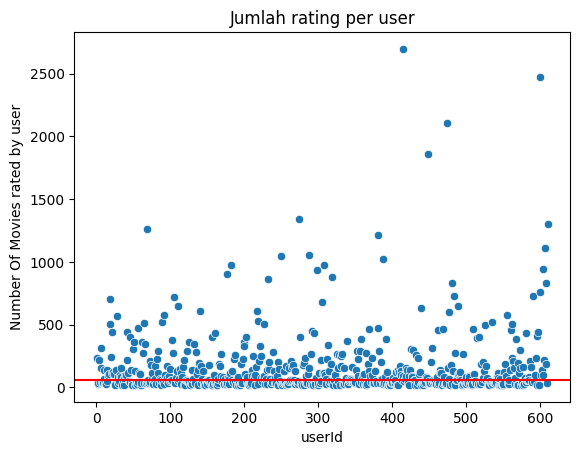

In [39]:
plt.figure()
sns.scatterplot(y='rating', x='userId', data=numberOf_movies_voted_by_user)
plt.axhline(y=60, color='r')
plt.ylabel('Number Of Movies rated by user')
plt.title('Jumlah rating per user')
plt.show()

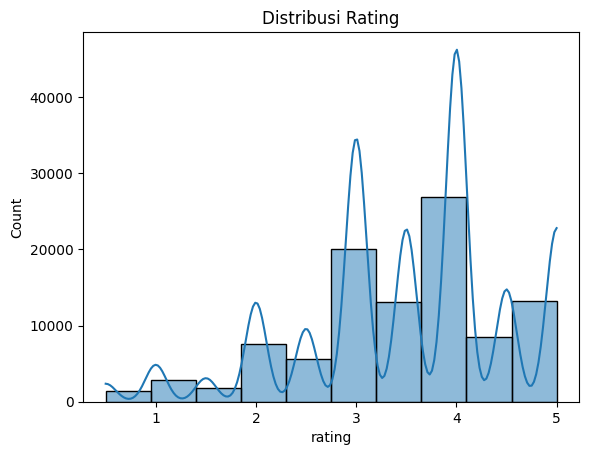

In [40]:
plt.figure()
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title("Distribusi Rating")
plt.show()

In [41]:
top_movies = ratings.groupby('movieId')['rating'].agg(['mean', 'count'])
top_movies = top_movies.merge(movies, on='movieId')
top_movies.sort_values('count', ascending=False).head(10)

,movieId,mean,count,title,genres
314,356,4.164134,329,Forrest Gump (1994),Comedy|Drama|Romance|War
277,318,4.429022,317,"Shawshank Redemption, The (1994)",Crime|Drama
257,296,4.197068,307,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
510,593,4.161290,279,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
1938,2571,4.192446,278,"Matrix, The (1999)",Action|Sci-Fi|Thriller
224,260,4.231076,251,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
418,480,3.750000,238,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
97,110,4.031646,237,Braveheart (1995),Action|Drama|War
507,589,3.970982,224,Terminator 2: Judgment Day (1991),Action|Sci-Fi
461,527,4.225000,220,Schindler's List (1993),Drama|War


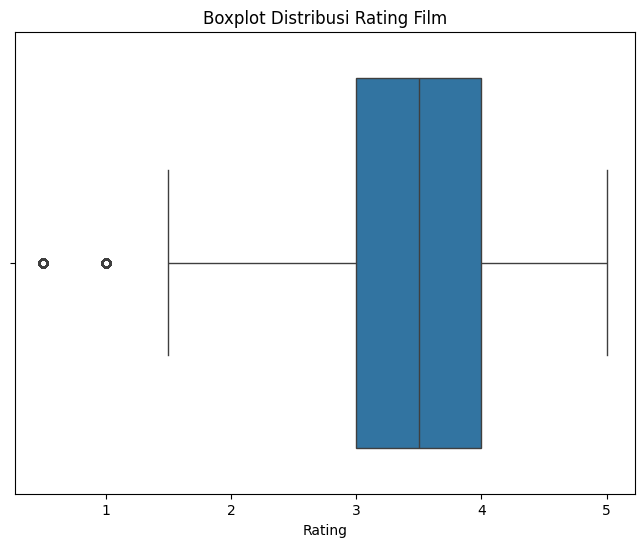

In [42]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=ratings['rating'])
plt.title('Boxplot Distribusi Rating Film')
plt.xlabel('Rating')
plt.show()

In [43]:
# 2. Hitung jumlah rating per film dan rata-rata rating
movie_stats = ratings.groupby('movieId').agg(
    rating_count=('rating', 'count'),
    rating_mean=('rating', 'mean')
).reset_index()

In [44]:
# Filter film dengan minimal 100 rating
popular_movies = movie_stats[movie_stats['rating_count'] > 100]

# Gabungkan dengan data judul film
popular_movies = popular_movies.merge(movies[['movieId', 'title']], on='movieId')

# Ambil top 10 film berdasarkan rating rata-rata tertinggi
top10_movies = popular_movies.sort_values(by='rating_mean', ascending=False).head(10)

print("Top 10 Film dengan Rating Tertinggi (dengan minimal 100 rating):")
print(top10_movies[['title', 'rating_mean', 'rating_count']])

Top 10 Film dengan Rating Tertinggi (dengan minimal 100 rating):
                                         title  rating_mean  rating_count
25            Shawshank Redemption, The (1994)     4.429022           317
58                       Godfather, The (1972)     4.289062           192
101                          Fight Club (1999)     4.272936           218
75              Godfather: Part II, The (1974)     4.259690           129
129                       Departed, The (2006)     4.252336           107
73                           Goodfellas (1990)     4.250000           126
130                    Dark Knight, The (2008)     4.238255           149
8                   Usual Suspects, The (1995)     4.237745           204
67                  Princess Bride, The (1987)     4.232394           142
20   Star Wars: Episode IV - A New Hope (1977)     4.231076           251


C:\Users\andri\AppData\Local\Temp\ipykernel_5432\1103701463.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_movies, x='rating_mean', y='title', palette='viridis')


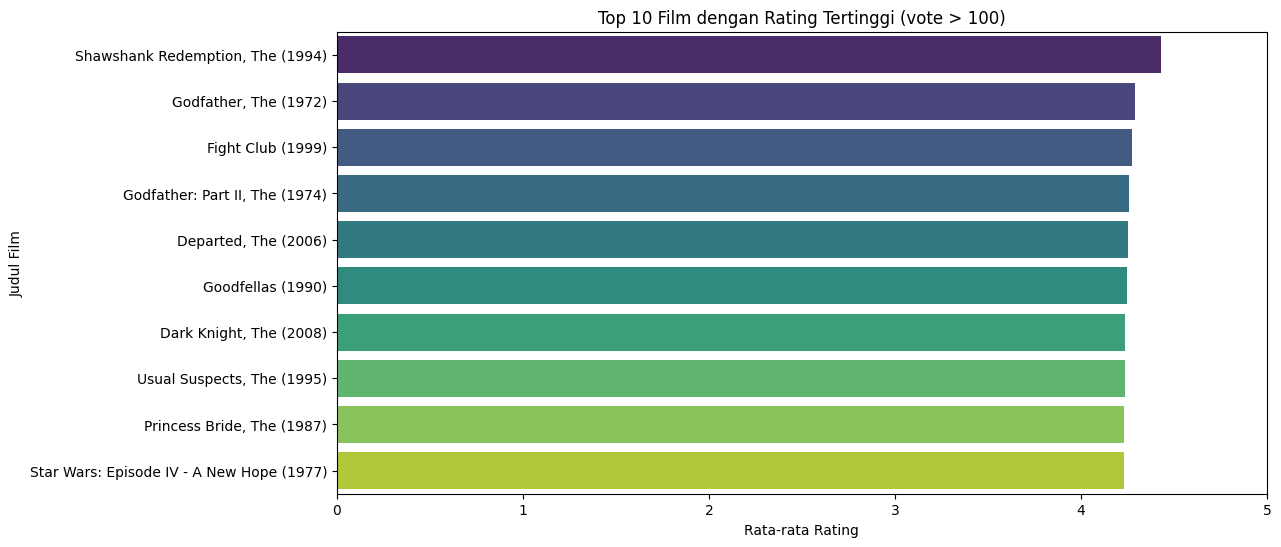

In [45]:
# Visualisasi top 10 film dengan barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=top10_movies, x='rating_mean', y='title', palette='viridis')
plt.xlabel('Rata-rata Rating')
plt.ylabel('Judul Film')
plt.title('Top 10 Film dengan Rating Tertinggi (vote > 100)')
plt.xlim(0, 5)  # Rentang rating 0-5
plt.show()

# **5. Data Preprocessing**

## 🧹 Preprocessing Data

Data difilter untuk menghilangkan user dan film dengan interaksi terlalu sedikit:
- Hanya menyertakan film dengan >10 rating.
- Hanya menyertakan user yang memberi >60 rating.

Matrix rating diubah menjadi **Compressed Sparse Row (CSR)** untuk efisiensi pemrosesan.

In [46]:
# 5. Data Preprocessing
data.fillna(0, inplace=True)
data_final = data.loc[numberOf_user_voted_for_movie[numberOf_user_voted_for_movie['rating'] > 10]['movieId'], :]
data_final = data_final.loc[:, numberOf_movies_voted_by_user[numberOf_movies_voted_by_user['rating'] > 60]['userId']]
data_final.reset_index(inplace=True)
csr_data = csr_matrix(data_final.drop('movieId', axis=1).values)

# **6. Pembangunan Model Collaborative Filtering (KNN)**

Pada tahap ini, dilakukan pembangunan sistem rekomendasi menggunakan pendekatan **Collaborative Filtering berbasis item** dengan algoritma **K-Nearest Neighbors (KNN)**. Metode ini mencari kesamaan antar item (film) berdasarkan pola rating dari pengguna.

### Tahapan Model

1. **Representasi Data**  
   Dataset diubah menjadi **matriks sparse (CSR – Compressed Sparse Row)**, di mana baris merepresentasikan film dan kolom merepresentasikan pengguna, dengan nilai berupa rating.

2. **Pemodelan KNN**  
   Model KNN dilatih menggunakan **metrik cosine similarity** untuk mengukur kedekatan antar film berdasarkan pola rating pengguna.

3. **Fungsi Rekomendasi**
   - Menerima input berupa **nama film**.
   - Mencari **ID film** yang cocok.
   - Mengambil film-film yang paling mirip berdasarkan hasil dari `kneighbors`.
   - Mengembalikan daftar **rekomendasi film beserta tingkat kemiripannya** (cosine distance).

### Tujuan

Memberikan **rekomendasi film serupa** berdasarkan pola rating pengguna lain terhadap film tersebut. Pendekatan ini efektif ketika terdapat cukup data interaksi pengguna dan item, **meskipun tidak memperhitungkan informasi tambahan** seperti genre, sinopsis, atau profil pengguna.


In [47]:
# 6. Pembangunan Model Collaborative Filtering (KNN)
# Buat TF-IDF matrix untuk judul film (sekali saja, di luar fungsi)
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['title'])

# Buat model KNN dengan metric cosine similarity dan algoritma brute force
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(csr_data)

# Precompute rata-rata rating tiap film untuk lookup cepat
movie_rating_mean = ratings.groupby('movieId')['rating'].mean()

def get_movie_recommendation(movie_name):
    n = 10
    
    # 1. Cari film dengan str.contains dulu
    movie_list = movies[movies['title'].str.contains(movie_name, case=False)]
    
    # 2. Jika tidak ada hasil, pakai TF-IDF + cosine similarity untuk cari judul mirip
    if len(movie_list) == 0:
        # Vectorize input movie_name
        movie_name_tfidf = tfidf.transform([movie_name])
        # Hitung cosine similarity dengan semua judul film
        cosine_sim = cosine_similarity(movie_name_tfidf, tfidf_matrix).flatten()
        # Ambil indeks film dengan similarity tertinggi > threshold (misal 0.3)
        max_sim_idx = np.argmax(cosine_sim)
        if cosine_sim[max_sim_idx] < 0.3:
            return "Tidak ditemukan judul film yang cocok. Silakan cek kembali input."
        movie_list = movies.iloc[[max_sim_idx]]
    
    movie_id = movie_list.iloc[0]['movieId']
    if movie_id not in data_final['movieId'].values:
        return "Film tersebut tidak ada dalam model rekomendasi."
    
    movie_idx = data_final[data_final['movieId'] == movie_id].index[0]
    distances, indices = knn.kneighbors(csr_data[movie_idx], n_neighbors=n+1)
    rec_movie_indices = sorted(list(zip(indices.squeeze(), distances.squeeze())), key=lambda x: x[1])[1:]
    
    recommendations = []
    for val in rec_movie_indices:
        rec_id = data_final.iloc[val[0]]['movieId']
        title = movies[movies['movieId'] == rec_id]['title'].values[0]
        rating = movie_rating_mean.get(rec_id, np.nan)  # Ambil rata-rata rating atau NaN jika tidak ada
        recommendations.append((title, rating, val[1]))
    
    return pd.DataFrame(recommendations, columns=['Title', 'Average Rating', 'Distance']).set_index('Distance')


# **7. Deep Learning Model (Optional - Embedding Based)**

Pada tahap ini, dilakukan pembangunan model rekomendasi berbasis *deep learning* yang memanfaatkan embedding untuk memetakan pengguna dan item (film) ke dalam vektor berdimensi rendah. Vektor ini mewakili preferensi pengguna dan karakteristik film dalam ruang laten.

### Tahapan model:

1. **Input Layer**: Model menerima pasangan input berupa ID pengguna dan ID film.
2. **Embedding Layer**: ID pengguna dan ID film diubah menjadi representasi vektor (embedding).
3. **Concatenation**: Embedding pengguna dan film digabungkan.
4. **Dense Layer**: Hasil gabungan diproses oleh layer fully connected (dense) untuk belajar representasi interaksi.
5. **Output Layer**: Menghasilkan prediksi rating (regresi).

### Tujuan:
Memprediksi rating yang mungkin diberikan pengguna terhadap suatu film berdasarkan pola interaksi sebelumnya.

Model dikompilasi dengan fungsi loss mean_squared_error, karena targetnya adalah memprediksi nilai rating kontinu.

In [48]:
user_ids = ratings['userId'].unique().tolist()
movie_ids = ratings['movieId'].unique().tolist()

user2user_encoded = {x: i for i, x in enumerate(user_ids)}
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movieencoded2movie = {i: x for i, x in enumerate(movie_ids)}

ratings['user'] = ratings['userId'].map(user2user_encoded)
ratings['movie'] = ratings['movieId'].map(movie2movie_encoded)


In [49]:
x = ratings[['user', 'movie']].values
y = ratings['rating'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [50]:
# 7. Deep Learning Model
# Jumlah user dan movie
num_users = len(user2user_encoded)
num_movies = len(movie2movie_encoded)

# Ukuran embedding
embedding_size = 50

# Input untuk user
user_input = Input(shape=(1,))
user_embedding = Embedding(num_users, embedding_size, embeddings_initializer='he_normal')(user_input)
user_vec = Flatten()(user_embedding)

# Input untuk movie
movie_input = Input(shape=(1,))
movie_embedding = Embedding(num_movies, embedding_size, embeddings_initializer='he_normal')(movie_input)
movie_vec = Flatten()(movie_embedding)

# Gabungkan user dan movie embedding
concat = Concatenate()([user_vec, movie_vec])
dense = Dense(128, activation='relu', kernel_regularizer=l2(1e-5))(concat)
batchnorm1 = BatchNormalization()(dense)
dropout1 = Dropout(0.6)(batchnorm1)

dense2 = Dense(64, activation='relu', kernel_regularizer=l2(1e-5))(dropout1)
batchnorm2 = BatchNormalization()(dense2)
dropout2 = Dropout(0.5)(batchnorm2)

output = Dense(1)(dropout2)

# Buat model
model = Model([user_input, movie_input], output)
model.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.001),
    metrics=[MeanAbsoluteError()]
)

# Ringkasan model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 1, 50)                30500     ['input_3[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 1, 50)                486200    ['input_4[0][0]']             
                                                                                            

In [51]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [52]:
# Training model
history = model.fit(
    [x_train[:, 0], x_train[:, 1]],
    y_train,
    validation_data=([x_test[:, 0], x_test[:, 1]], y_test),
    epochs=50,
    batch_size=128,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
631/631 [==============================] - 7s 9ms/step - loss: 4.9748 - mean_absolute_error: 1.7455 - val_loss: 0.9686 - val_mean_absolute_error: 0.7619 - lr: 0.0010
Epoch 2/50
631/631 [==============================] - 5s 8ms/step - loss: 1.4791 - mean_absolute_error: 0.9654 - val_loss: 0.8609 - val_mean_absolute_error: 0.7185 - lr: 0.0010
Epoch 3/50
631/631 [==============================] - 5s 8ms/step - loss: 1.1412 - mean_absolute_error: 0.8432 - val_loss: 0.8022 - val_mean_absolute_error: 0.6884 - lr: 0.0010
Epoch 4/50
631/631 [==============================] - 6s 9ms/step - loss: 0.9861 - mean_absolute_error: 0.7811 - val_loss: 0.7865 - val_mean_absolute_error: 0.6779 - lr: 0.0010
Epoch 5/50
631/631 [==============================] - 6s 9ms/step - loss: 0.8954 - mean_absolute_error: 0.7418 - val_loss: 0.7778 - val_mean_absolute_error: 0.6758 - lr: 0.0010
Epoch 6/50
631/631 [==============================] - 5s 9ms/step - loss: 0.8367 - mean_absolute_error: 0.7145 - va

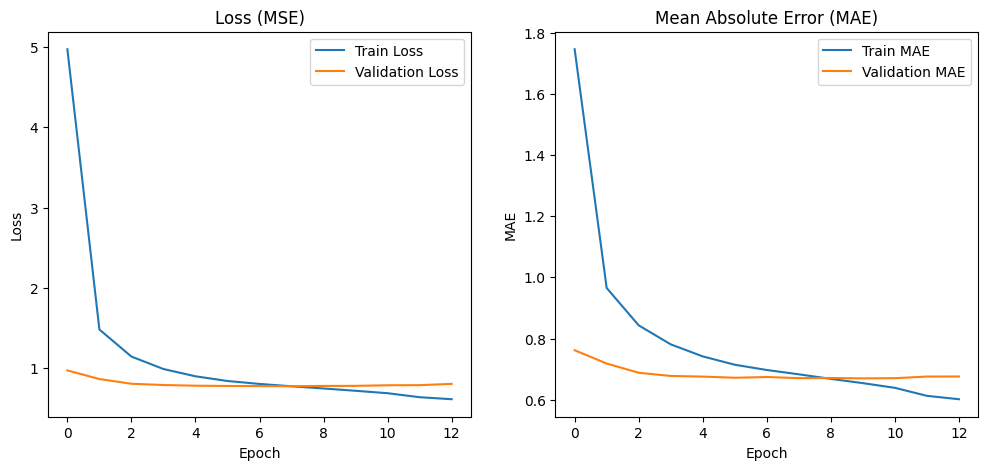

In [53]:
# Plot hasil training
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()


# **8. Evaluasi dengan RMSE**

631/631 [==============================] - 1s 1ms/step
=== Evaluasi Model ===
Mean Squared Error (MSE): 0.7696
Root Mean Squared Error (RMSE): 0.8773
Mean Absolute Error (MAE): 0.6707


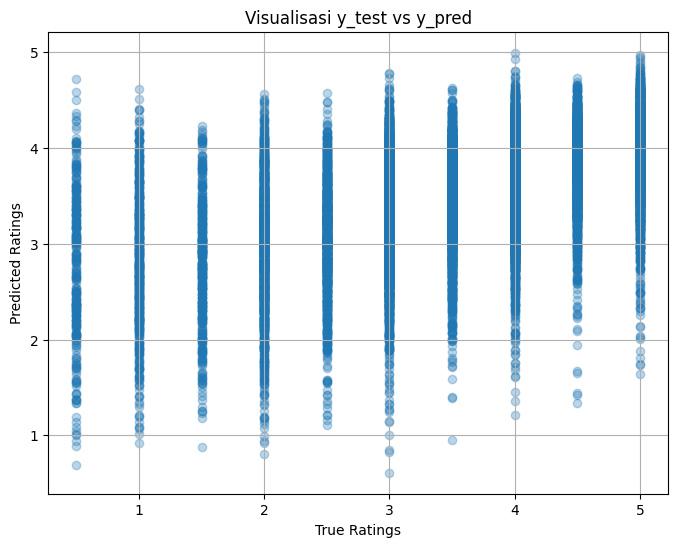

In [54]:
# Prediksi di data test
y_pred = model.predict([x_test[:, 0], x_test[:, 1]]).flatten()
y_true = y_test

# Evaluasi metrik
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

# Evaluasi dari model.evaluate (menggunakan loss & MAE internal model)
test_loss, test_mae = model.evaluate([x_test[:, 0], x_test[:, 1]], y_test, verbose=0)

# Tampilkan hasil
print("=== Evaluasi Model ===")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Visualisasi y_test vs y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("True Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Visualisasi y_test vs y_pred")
plt.grid(True)
plt.show()

# **9. Fungsi Rekomendasi Berdasarkan User ID dengan Model DL**

In [55]:
def recommend_movies_for_user(user_id, num_recommendations=10):
    encoded_user_id = user2user_encoded.get(user_id)
    if encoded_user_id is None:
        return "User tidak ditemukan dalam dataset."
    
    movie_array = np.array([i for i in range(num_movies)])
    user_array = np.full(num_movies, encoded_user_id)

    predicted_ratings = model.predict([user_array, movie_array], verbose=0).flatten()
    top_indices = predicted_ratings.argsort()[-num_recommendations:][::-1]
    
    recommended_movie_ids = [movieencoded2movie[i] for i in top_indices]
    recommended_titles = movies[movies['movieId'].isin(recommended_movie_ids)][['movieId', 'title']]
    
    recommended_titles['Predicted Rating'] = predicted_ratings[top_indices]
    return recommended_titles.sort_values(by='Predicted Rating', ascending=False).reset_index(drop=True)

# **10. Contoh Pemakaian Fungsi**

In [56]:
get_movie_recommendation('Captain America: The Winter Soldier')

,Title,Average Rating
Distance,,
0.178672,Avengers: Age of Ultron (2015),3.518519
0.282725,Iron Man 3 (2013),3.562500
0.291153,Captain America: Civil War (2016),3.613636
0.305744,Thor: The Dark World (2013),3.309524
0.332650,Star Trek Into Darkness (2013),3.685185
0.335886,X-Men: Days of Future Past (2014),3.833333
0.336878,"Avengers, The (2012)",3.869565
0.345686,Guardians of the Galaxy (2014),4.050847
0.370297,Iron Man 2 (2010),3.510638


In [57]:
recommend_movies_for_user(user_id=3, num_recommendations=10)

,movieId,title,Predicted Rating
0,53,Lamerica (1994),4.116498
1,1310,Hype! (1996),4.114814
2,5746,Galaxy of Terror (Quest) (1981),4.086152
3,26409,"Clonus Horror, The (1979)",4.081616
4,53280,"Breed, The (2006)",4.033873
5,70946,Troll 2 (1990),4.032768
6,121469,Killer Movie (2008),4.025820
7,131130,Tom and Jerry: A Nutcracker Tale (2007),3.973920
8,131610,Willy/Milly (1986),3.970175
9,158966,Captain Fantastic (2016),3.958764
